In [26]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [27]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 0")
    device_num = 0
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_folds = 15

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 160
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-Middle-StdDevExtended-ExtrudedNS"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 0
Num images / labels = 62 62


In [28]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


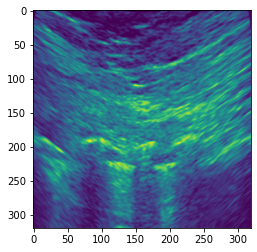

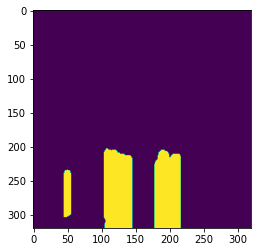

In [29]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [32]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [33]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


torch.Size([4, 4, 160, 320])
torch.Size([4, 160, 320])
image shape: torch.Size([4, 160, 320]), label shape: torch.Size([1, 160, 320])


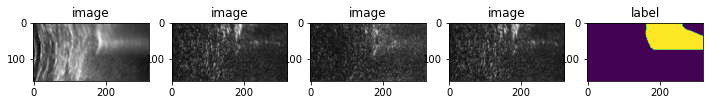

tensor(0.) tensor(2.)


In [34]:
imgnum = 2
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [35]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [36]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(device_num,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7334
2/0, train_loss: 0.7260
3/0, train_loss: 0.7057
4/0, train_loss: 0.6944
0 epoch 1 average loss: 0.7149
----------
0: epoch 2/500
1/0, train_loss: 0.6894
2/0, train_loss: 0.6924
3/0, train_loss: 0.6971
4/0, train_loss: 0.6790
0 epoch 2 average loss: 0.6895
saved new best metric model
current epoch: 2 current mean dice: 0.0884
best mean dice: 0.0884 at epoch: 2
----------
0: epoch 3/500
1/0, train_loss: 0.6784
2/0, train_loss: 0.6832
3/0, train_loss: 0.6789
4/0, train_loss: 0.6597
0 epoch 3 average loss: 0.6751
----------
0: epoch 4/500
1/0, train_loss: 0.6697
2/0, train_loss: 0.6682
3/0, train_loss: 0.6646
4/0, train_loss: 0.6832
0 epoch 4 average loss: 0.6714
saved new best metric model
current epoch: 4 current mean dice: 0.2714
best mean dice: 0.2714 at epoch: 4
----------
0: epoch 5/500
1/0, train_loss: 0.6690
2/0, train_loss: 0.6505
3/0, train_loss: 0.6684
4/0, train_loss: 0.6467
0 epoch 5 average loss: 0.6587
----------
0: epoch 6/5

0 epoch 41 average loss: 0.5649
----------
0: epoch 42/500
1/0, train_loss: 0.5721
2/0, train_loss: 0.5370
3/0, train_loss: 0.5846
4/0, train_loss: 0.5385
0 epoch 42 average loss: 0.5580
saved new best metric model
current epoch: 42 current mean dice: 0.7827
best mean dice: 0.7827 at epoch: 42
----------
0: epoch 43/500
1/0, train_loss: 0.5588
2/0, train_loss: 0.5505
3/0, train_loss: 0.5509
4/0, train_loss: 0.5261
0 epoch 43 average loss: 0.5466
----------
0: epoch 44/500
1/0, train_loss: 0.5595
2/0, train_loss: 0.5472
3/0, train_loss: 0.5732
4/0, train_loss: 0.5324
0 epoch 44 average loss: 0.5531
current epoch: 44 current mean dice: 0.7798
best mean dice: 0.7827 at epoch: 42
----------
0: epoch 45/500
1/0, train_loss: 0.5327
2/0, train_loss: 0.5504
3/0, train_loss: 0.5781
4/0, train_loss: 0.5349
0 epoch 45 average loss: 0.5490
----------
0: epoch 46/500
1/0, train_loss: 0.5439
2/0, train_loss: 0.5483
3/0, train_loss: 0.5777
4/0, train_loss: 0.5600
0 epoch 46 average loss: 0.5575
curre

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e284175e0>
Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e284175e0>
Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/s

2/0, train_loss: 0.5519
3/0, train_loss: 0.5379
4/0, train_loss: 0.5678
0 epoch 53 average loss: 0.5494
----------
0: epoch 54/500
1/0, train_loss: 0.5582
2/0, train_loss: 0.5456
3/0, train_loss: 0.5454
4/0, train_loss: 0.5547
0 epoch 54 average loss: 0.5510
current epoch: 54 current mean dice: 0.7112
best mean dice: 0.7956 at epoch: 50
----------
0: epoch 55/500
1/0, train_loss: 0.5483
2/0, train_loss: 0.5535
3/0, train_loss: 0.5196
4/0, train_loss: 0.5430
0 epoch 55 average loss: 0.5411
----------
0: epoch 56/500
1/0, train_loss: 0.5426


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e284175e0>
Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2e284175e0>
Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/local/KHQ/s

2/0, train_loss: 0.5326
3/0, train_loss: 0.5457
4/0, train_loss: 0.5844
0 epoch 56 average loss: 0.5513
saved new best metric model
current epoch: 56 current mean dice: 0.7963
best mean dice: 0.7963 at epoch: 56
----------
0: epoch 57/500
1/0, train_loss: 0.5584
2/0, train_loss: 0.5475
3/0, train_loss: 0.5263
4/0, train_loss: 0.5405
0 epoch 57 average loss: 0.5432
----------
0: epoch 58/500
1/0, train_loss: 0.5398
2/0, train_loss: 0.5481
3/0, train_loss: 0.5437
4/0, train_loss: 0.5750
0 epoch 58 average loss: 0.5517
current epoch: 58 current mean dice: 0.7647
best mean dice: 0.7963 at epoch: 56
----------
0: epoch 59/500
1/0, train_loss: 0.5392
2/0, train_loss: 0.5468
3/0, train_loss: 0.5470
4/0, train_loss: 0.5748
0 epoch 59 average loss: 0.5520
----------
0: epoch 60/500
1/0, train_loss: 0.5509
2/0, train_loss: 0.5428
3/0, train_loss: 0.5619
4/0, train_loss: 0.5439
0 epoch 60 average loss: 0.5499
current epoch: 60 current mean dice: 0.6890
best mean dice: 0.7963 at epoch: 56
--------

1/0, train_loss: 0.5124
2/0, train_loss: 0.5083
3/0, train_loss: 0.5267
4/0, train_loss: 0.5556
0 epoch 98 average loss: 0.5258
current epoch: 98 current mean dice: 0.6911
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 99/500
1/0, train_loss: 0.4976
2/0, train_loss: 0.5337
3/0, train_loss: 0.5334
4/0, train_loss: 0.5335
0 epoch 99 average loss: 0.5245
----------
0: epoch 100/500
1/0, train_loss: 0.5051
2/0, train_loss: 0.5371
3/0, train_loss: 0.5092
4/0, train_loss: 0.5514
0 epoch 100 average loss: 0.5257
current epoch: 100 current mean dice: 0.6955
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 101/500
1/0, train_loss: 0.5444
2/0, train_loss: 0.5055
3/0, train_loss: 0.5157
4/0, train_loss: 0.5375
0 epoch 101 average loss: 0.5258
----------
0: epoch 102/500
1/0, train_loss: 0.5230
2/0, train_loss: 0.5280
3/0, train_loss: 0.5057
4/0, train_loss: 0.5207
0 epoch 102 average loss: 0.5194
current epoch: 102 current mean dice: 0.5197
best mean dice: 0.8178 at epoch: 82
----

0 epoch 139 average loss: 0.4938
----------
0: epoch 140/500
1/0, train_loss: 0.5031
2/0, train_loss: 0.5290
3/0, train_loss: 0.4998
4/0, train_loss: 0.5152
0 epoch 140 average loss: 0.5118
current epoch: 140 current mean dice: 0.5667
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 141/500
1/0, train_loss: 0.4935
2/0, train_loss: 0.5086
3/0, train_loss: 0.4755
4/0, train_loss: 0.5042
0 epoch 141 average loss: 0.4954
----------
0: epoch 142/500
1/0, train_loss: 0.5146
2/0, train_loss: 0.5186
3/0, train_loss: 0.4994
4/0, train_loss: 0.4544
0 epoch 142 average loss: 0.4967
current epoch: 142 current mean dice: 0.6815
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 143/500
1/0, train_loss: 0.5099
2/0, train_loss: 0.5024
3/0, train_loss: 0.5155
4/0, train_loss: 0.4714
0 epoch 143 average loss: 0.4998
----------
0: epoch 144/500
1/0, train_loss: 0.4893
2/0, train_loss: 0.4990
3/0, train_loss: 0.4957
4/0, train_loss: 0.5048
0 epoch 144 average loss: 0.4972
current epoch: 144 c

1/0, train_loss: 0.4657
2/0, train_loss: 0.4829
3/0, train_loss: 0.5025
4/0, train_loss: 0.4920
0 epoch 181 average loss: 0.4858
----------
0: epoch 182/500
1/0, train_loss: 0.4855
2/0, train_loss: 0.4717
3/0, train_loss: 0.5043
4/0, train_loss: 0.5122
0 epoch 182 average loss: 0.4934
current epoch: 182 current mean dice: 0.6617
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 183/500
1/0, train_loss: 0.4891
2/0, train_loss: 0.4908
3/0, train_loss: 0.5222
4/0, train_loss: 0.4635
0 epoch 183 average loss: 0.4914
----------
0: epoch 184/500
1/0, train_loss: 0.4571
2/0, train_loss: 0.4712
3/0, train_loss: 0.4829
4/0, train_loss: 0.5431
0 epoch 184 average loss: 0.4886
current epoch: 184 current mean dice: 0.5130
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 185/500
1/0, train_loss: 0.4786
2/0, train_loss: 0.4786
3/0, train_loss: 0.4898
4/0, train_loss: 0.4828
0 epoch 185 average loss: 0.4824
----------
0: epoch 186/500
1/0, train_loss: 0.4824
2/0, train_loss: 0.4944
3/0, 

1/0, train_loss: 0.4605
2/0, train_loss: 0.4631
3/0, train_loss: 0.4799
4/0, train_loss: 0.5335
0 epoch 223 average loss: 0.4843
----------
0: epoch 224/500
1/0, train_loss: 0.4787
2/0, train_loss: 0.4821
3/0, train_loss: 0.4602
4/0, train_loss: 0.4627
0 epoch 224 average loss: 0.4709
current epoch: 224 current mean dice: 0.7071
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 225/500
1/0, train_loss: 0.4820
2/0, train_loss: 0.4848
3/0, train_loss: 0.4797
4/0, train_loss: 0.4815
0 epoch 225 average loss: 0.4820
----------
0: epoch 226/500
1/0, train_loss: 0.4921
2/0, train_loss: 0.4564
3/0, train_loss: 0.4880
4/0, train_loss: 0.4622
0 epoch 226 average loss: 0.4747
current epoch: 226 current mean dice: 0.6559
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 227/500
1/0, train_loss: 0.4715
2/0, train_loss: 0.4746
3/0, train_loss: 0.4837
4/0, train_loss: 0.5007
0 epoch 227 average loss: 0.4826
----------
0: epoch 228/500
1/0, train_loss: 0.4788
2/0, train_loss: 0.4708
3/0, 

1/0, train_loss: 0.4798
2/0, train_loss: 0.4609
3/0, train_loss: 0.4871
4/0, train_loss: 0.4693
0 epoch 265 average loss: 0.4743
----------
0: epoch 266/500
1/0, train_loss: 0.4750
2/0, train_loss: 0.4765
3/0, train_loss: 0.4533
4/0, train_loss: 0.5428
0 epoch 266 average loss: 0.4869
current epoch: 266 current mean dice: 0.7281
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 267/500
1/0, train_loss: 0.4819
2/0, train_loss: 0.4462
3/0, train_loss: 0.4586
4/0, train_loss: 0.4676
0 epoch 267 average loss: 0.4636
----------
0: epoch 268/500
1/0, train_loss: 0.4892
2/0, train_loss: 0.4493
3/0, train_loss: 0.4631
4/0, train_loss: 0.4621
0 epoch 268 average loss: 0.4659
current epoch: 268 current mean dice: 0.6520
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 269/500
1/0, train_loss: 0.4610
2/0, train_loss: 0.4630
3/0, train_loss: 0.4663
4/0, train_loss: 0.4481
0 epoch 269 average loss: 0.4596
----------
0: epoch 270/500
1/0, train_loss: 0.4683
2/0, train_loss: 0.4592
3/0, 

1/0, train_loss: 0.4635
2/0, train_loss: 0.4845
3/0, train_loss: 0.4741
4/0, train_loss: 0.5039
0 epoch 307 average loss: 0.4815
----------
0: epoch 308/500
1/0, train_loss: 0.4619
2/0, train_loss: 0.4724
3/0, train_loss: 0.4806
4/0, train_loss: 0.4507
0 epoch 308 average loss: 0.4664
current epoch: 308 current mean dice: 0.7785
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 309/500
1/0, train_loss: 0.4719
2/0, train_loss: 0.4511
3/0, train_loss: 0.4602
4/0, train_loss: 0.5210
0 epoch 309 average loss: 0.4760
----------
0: epoch 310/500
1/0, train_loss: 0.4669
2/0, train_loss: 0.4565
3/0, train_loss: 0.4683
4/0, train_loss: 0.4978
0 epoch 310 average loss: 0.4724
current epoch: 310 current mean dice: 0.6700
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 311/500
1/0, train_loss: 0.4631
2/0, train_loss: 0.4582
3/0, train_loss: 0.4770
4/0, train_loss: 0.4527
0 epoch 311 average loss: 0.4627
----------
0: epoch 312/500
1/0, train_loss: 0.4468
2/0, train_loss: 0.4914
3/0, 

1/0, train_loss: 0.4785
2/0, train_loss: 0.4279
3/0, train_loss: 0.4683
4/0, train_loss: 0.4466
0 epoch 349 average loss: 0.4553
----------
0: epoch 350/500
1/0, train_loss: 0.4569
2/0, train_loss: 0.4544
3/0, train_loss: 0.4410
4/0, train_loss: 0.5166
0 epoch 350 average loss: 0.4672
current epoch: 350 current mean dice: 0.5376
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 351/500
1/0, train_loss: 0.4552
2/0, train_loss: 0.4766
3/0, train_loss: 0.4382
4/0, train_loss: 0.4833
0 epoch 351 average loss: 0.4633
----------
0: epoch 352/500
1/0, train_loss: 0.4567
2/0, train_loss: 0.4713
3/0, train_loss: 0.4486
4/0, train_loss: 0.4375
0 epoch 352 average loss: 0.4536
current epoch: 352 current mean dice: 0.6677
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 353/500
1/0, train_loss: 0.4436
2/0, train_loss: 0.4536
3/0, train_loss: 0.4836
4/0, train_loss: 0.4581
0 epoch 353 average loss: 0.4597
----------
0: epoch 354/500
1/0, train_loss: 0.4549
2/0, train_loss: 0.4588
3/0, 

1/0, train_loss: 0.4624
2/0, train_loss: 0.4497
3/0, train_loss: 0.4501
4/0, train_loss: 0.4364
0 epoch 391 average loss: 0.4496
----------
0: epoch 392/500
1/0, train_loss: 0.4783
2/0, train_loss: 0.4548
3/0, train_loss: 0.4651
4/0, train_loss: 0.4429
0 epoch 392 average loss: 0.4603
current epoch: 392 current mean dice: 0.6837
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 393/500
1/0, train_loss: 0.4892
2/0, train_loss: 0.4387
3/0, train_loss: 0.4434
4/0, train_loss: 0.4396
0 epoch 393 average loss: 0.4527
----------
0: epoch 394/500
1/0, train_loss: 0.4388
2/0, train_loss: 0.4616
3/0, train_loss: 0.4435
4/0, train_loss: 0.4749
0 epoch 394 average loss: 0.4547
current epoch: 394 current mean dice: 0.7532
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 395/500
1/0, train_loss: 0.4396
2/0, train_loss: 0.4590
3/0, train_loss: 0.4674
4/0, train_loss: 0.4510
0 epoch 395 average loss: 0.4543
----------
0: epoch 396/500
1/0, train_loss: 0.4632
2/0, train_loss: 0.4397
3/0, 

1/0, train_loss: 0.4282
2/0, train_loss: 0.4588
3/0, train_loss: 0.4513
4/0, train_loss: 0.4785
0 epoch 433 average loss: 0.4542
----------
0: epoch 434/500
1/0, train_loss: 0.4514
2/0, train_loss: 0.4377
3/0, train_loss: 0.4474
4/0, train_loss: 0.4557
0 epoch 434 average loss: 0.4480
current epoch: 434 current mean dice: 0.8004
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 435/500
1/0, train_loss: 0.4512
2/0, train_loss: 0.4222
3/0, train_loss: 0.4544
4/0, train_loss: 0.4722
0 epoch 435 average loss: 0.4500
----------
0: epoch 436/500
1/0, train_loss: 0.4278
2/0, train_loss: 0.4595
3/0, train_loss: 0.4630
4/0, train_loss: 0.4552
0 epoch 436 average loss: 0.4514
current epoch: 436 current mean dice: 0.6815
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 437/500
1/0, train_loss: 0.4361
2/0, train_loss: 0.4306
3/0, train_loss: 0.4602
4/0, train_loss: 0.4196
0 epoch 437 average loss: 0.4366
----------
0: epoch 438/500
1/0, train_loss: 0.4477
2/0, train_loss: 0.4598
3/0, 

1/0, train_loss: 0.4328
2/0, train_loss: 0.4293
3/0, train_loss: 0.4676
4/0, train_loss: 0.4567
0 epoch 475 average loss: 0.4466
----------
0: epoch 476/500
1/0, train_loss: 0.4496
2/0, train_loss: 0.4518
3/0, train_loss: 0.4294
4/0, train_loss: 0.4230
0 epoch 476 average loss: 0.4384
current epoch: 476 current mean dice: 0.7281
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 477/500
1/0, train_loss: 0.4286
2/0, train_loss: 0.4585
3/0, train_loss: 0.4489
4/0, train_loss: 0.4131
0 epoch 477 average loss: 0.4373
----------
0: epoch 478/500
1/0, train_loss: 0.4717
2/0, train_loss: 0.4298
3/0, train_loss: 0.4225
4/0, train_loss: 0.4361
0 epoch 478 average loss: 0.4400
current epoch: 478 current mean dice: 0.6863
best mean dice: 0.8178 at epoch: 82
----------
0: epoch 479/500
1/0, train_loss: 0.4409
2/0, train_loss: 0.4595
3/0, train_loss: 0.4337
4/0, train_loss: 0.4629
0 epoch 479 average loss: 0.4492
----------
0: epoch 480/500
1/0, train_loss: 0.4485
2/0, train_loss: 0.4380
3/0, 

1 epoch 16 average loss: 0.6328
current epoch: 16 current mean dice: 0.2527
best mean dice: 0.2683 at epoch: 14
----------
1: epoch 17/500
1/0, train_loss: 0.6196
2/0, train_loss: 0.6231
3/0, train_loss: 0.6392
4/0, train_loss: 0.6272
1 epoch 17 average loss: 0.6273
----------
1: epoch 18/500
1/0, train_loss: 0.6288
2/0, train_loss: 0.6432
3/0, train_loss: 0.6212
4/0, train_loss: 0.6525
1 epoch 18 average loss: 0.6364
saved new best metric model
current epoch: 18 current mean dice: 0.3636
best mean dice: 0.3636 at epoch: 18
----------
1: epoch 19/500
1/0, train_loss: 0.6191
2/0, train_loss: 0.6132
3/0, train_loss: 0.6411
4/0, train_loss: 0.5875
1 epoch 19 average loss: 0.6152
----------
1: epoch 20/500
1/0, train_loss: 0.6068
2/0, train_loss: 0.6242
3/0, train_loss: 0.6462
4/0, train_loss: 0.6195
1 epoch 20 average loss: 0.6242
saved new best metric model
current epoch: 20 current mean dice: 0.4189
best mean dice: 0.4189 at epoch: 20
----------
1: epoch 21/500
1/0, train_loss: 0.6215
2

1 epoch 57 average loss: 0.5608
----------
1: epoch 58/500
1/0, train_loss: 0.5820
2/0, train_loss: 0.5323
3/0, train_loss: 0.5639
4/0, train_loss: 0.5884
1 epoch 58 average loss: 0.5667
saved new best metric model
current epoch: 58 current mean dice: 0.5952
best mean dice: 0.5952 at epoch: 58
----------
1: epoch 59/500
1/0, train_loss: 0.5739
2/0, train_loss: 0.5733
3/0, train_loss: 0.5576
4/0, train_loss: 0.5483
1 epoch 59 average loss: 0.5633
----------
1: epoch 60/500
1/0, train_loss: 0.5516
2/0, train_loss: 0.5575
3/0, train_loss: 0.5600
4/0, train_loss: 0.5730
1 epoch 60 average loss: 0.5605
current epoch: 60 current mean dice: 0.5464
best mean dice: 0.5952 at epoch: 58
----------
1: epoch 61/500
1/0, train_loss: 0.5583
2/0, train_loss: 0.5590
3/0, train_loss: 0.5573
4/0, train_loss: 0.6094
1 epoch 61 average loss: 0.5710
----------
1: epoch 62/500
1/0, train_loss: 0.5692
2/0, train_loss: 0.5273
3/0, train_loss: 0.5677
4/0, train_loss: 0.5871
1 epoch 62 average loss: 0.5628
saved

1/0, train_loss: 0.5285
2/0, train_loss: 0.5215
3/0, train_loss: 0.5455
4/0, train_loss: 0.5061
1 epoch 99 average loss: 0.5254
----------
1: epoch 100/500
1/0, train_loss: 0.5094
2/0, train_loss: 0.5619
3/0, train_loss: 0.5423
4/0, train_loss: 0.5401
1 epoch 100 average loss: 0.5384
current epoch: 100 current mean dice: 0.6297
best mean dice: 0.6794 at epoch: 88
----------
1: epoch 101/500
1/0, train_loss: 0.5385
2/0, train_loss: 0.5422
3/0, train_loss: 0.5587
4/0, train_loss: 0.4814
1 epoch 101 average loss: 0.5302
----------
1: epoch 102/500
1/0, train_loss: 0.5266
2/0, train_loss: 0.5497
3/0, train_loss: 0.5249
4/0, train_loss: 0.5735
1 epoch 102 average loss: 0.5437
current epoch: 102 current mean dice: 0.5912
best mean dice: 0.6794 at epoch: 88
----------
1: epoch 103/500
1/0, train_loss: 0.5174
2/0, train_loss: 0.5301
3/0, train_loss: 0.5365
4/0, train_loss: 0.5277
1 epoch 103 average loss: 0.5279
----------
1: epoch 104/500
1/0, train_loss: 0.5318
2/0, train_loss: 0.5233
3/0, t

current epoch: 140 current mean dice: 0.6747
best mean dice: 0.6833 at epoch: 132
----------
1: epoch 141/500
1/0, train_loss: 0.5111
2/0, train_loss: 0.5009
3/0, train_loss: 0.5189
4/0, train_loss: 0.5862
1 epoch 141 average loss: 0.5293
----------
1: epoch 142/500
1/0, train_loss: 0.5222
2/0, train_loss: 0.5085
3/0, train_loss: 0.5074
4/0, train_loss: 0.4790
1 epoch 142 average loss: 0.5043
current epoch: 142 current mean dice: 0.6399
best mean dice: 0.6833 at epoch: 132
----------
1: epoch 143/500
1/0, train_loss: 0.5148
2/0, train_loss: 0.4995
3/0, train_loss: 0.5280
4/0, train_loss: 0.5266
1 epoch 143 average loss: 0.5172
----------
1: epoch 144/500
1/0, train_loss: 0.5021
2/0, train_loss: 0.5254
3/0, train_loss: 0.5141
4/0, train_loss: 0.5179
1 epoch 144 average loss: 0.5149
current epoch: 144 current mean dice: 0.6085
best mean dice: 0.6833 at epoch: 132
----------
1: epoch 145/500
1/0, train_loss: 0.4939
2/0, train_loss: 0.5430
3/0, train_loss: 0.5194
4/0, train_loss: 0.5029
1 

2/0, train_loss: 0.4986
3/0, train_loss: 0.4928
4/0, train_loss: 0.5159
1 epoch 182 average loss: 0.4995
current epoch: 182 current mean dice: 0.6331
best mean dice: 0.6833 at epoch: 132
----------
1: epoch 183/500
1/0, train_loss: 0.4980
2/0, train_loss: 0.4767
3/0, train_loss: 0.5002
4/0, train_loss: 0.4924
1 epoch 183 average loss: 0.4918
----------
1: epoch 184/500
1/0, train_loss: 0.4834
2/0, train_loss: 0.5001
3/0, train_loss: 0.4947
4/0, train_loss: 0.5351
1 epoch 184 average loss: 0.5033
saved new best metric model
current epoch: 184 current mean dice: 0.6870
best mean dice: 0.6870 at epoch: 184
----------
1: epoch 185/500
1/0, train_loss: 0.5119
2/0, train_loss: 0.4812
3/0, train_loss: 0.4764
4/0, train_loss: 0.5472
1 epoch 185 average loss: 0.5042
----------
1: epoch 186/500
1/0, train_loss: 0.4966
2/0, train_loss: 0.5015
3/0, train_loss: 0.4836
4/0, train_loss: 0.5280
1 epoch 186 average loss: 0.5025
current epoch: 186 current mean dice: 0.6047
best mean dice: 0.6870 at epoc

2/0, train_loss: 0.4851
3/0, train_loss: 0.4906
4/0, train_loss: 0.4501
1 epoch 223 average loss: 0.4737
----------
1: epoch 224/500
1/0, train_loss: 0.4743
2/0, train_loss: 0.4780
3/0, train_loss: 0.4771
4/0, train_loss: 0.5353
1 epoch 224 average loss: 0.4912
current epoch: 224 current mean dice: 0.6247
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 225/500
1/0, train_loss: 0.4976
2/0, train_loss: 0.4720
3/0, train_loss: 0.4724
4/0, train_loss: 0.4856
1 epoch 225 average loss: 0.4819
----------
1: epoch 226/500
1/0, train_loss: 0.4712
2/0, train_loss: 0.4597
3/0, train_loss: 0.5083
4/0, train_loss: 0.5396
1 epoch 226 average loss: 0.4947
current epoch: 226 current mean dice: 0.5631
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 227/500
1/0, train_loss: 0.4797
2/0, train_loss: 0.4864
3/0, train_loss: 0.4833
4/0, train_loss: 0.5039
1 epoch 227 average loss: 0.4883
----------
1: epoch 228/500
1/0, train_loss: 0.4946
2/0, train_loss: 0.4620
3/0, train_loss: 0.4770
4/0

1/0, train_loss: 0.4559
2/0, train_loss: 0.4946
3/0, train_loss: 0.4621
4/0, train_loss: 0.4696
1 epoch 265 average loss: 0.4706
----------
1: epoch 266/500
1/0, train_loss: 0.4607
2/0, train_loss: 0.4555
3/0, train_loss: 0.4739
4/0, train_loss: 0.5394
1 epoch 266 average loss: 0.4824
current epoch: 266 current mean dice: 0.5808
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 267/500
1/0, train_loss: 0.4832
2/0, train_loss: 0.4760
3/0, train_loss: 0.4683
4/0, train_loss: 0.4532
1 epoch 267 average loss: 0.4702
----------
1: epoch 268/500
1/0, train_loss: 0.4597
2/0, train_loss: 0.4744
3/0, train_loss: 0.4623
4/0, train_loss: 0.5357
1 epoch 268 average loss: 0.4830
current epoch: 268 current mean dice: 0.7025
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 269/500
1/0, train_loss: 0.4689
2/0, train_loss: 0.4616
3/0, train_loss: 0.4772
4/0, train_loss: 0.5374
1 epoch 269 average loss: 0.4863
----------
1: epoch 270/500
1/0, train_loss: 0.4745
2/0, train_loss: 0.4516
3/0

current epoch: 306 current mean dice: 0.6702
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 307/500
1/0, train_loss: 0.4575
2/0, train_loss: 0.4591
3/0, train_loss: 0.4697
4/0, train_loss: 0.4902
1 epoch 307 average loss: 0.4692
----------
1: epoch 308/500
1/0, train_loss: 0.4456
2/0, train_loss: 0.4888
3/0, train_loss: 0.4695
4/0, train_loss: 0.4684
1 epoch 308 average loss: 0.4681
current epoch: 308 current mean dice: 0.6294
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 309/500
1/0, train_loss: 0.4716
2/0, train_loss: 0.4389
3/0, train_loss: 0.4466
4/0, train_loss: 0.5066
1 epoch 309 average loss: 0.4659
----------
1: epoch 310/500
1/0, train_loss: 0.4602
2/0, train_loss: 0.4506
3/0, train_loss: 0.4586
4/0, train_loss: 0.4844
1 epoch 310 average loss: 0.4634
current epoch: 310 current mean dice: 0.6978
best mean dice: 0.7031 at epoch: 196
----------
1: epoch 311/500
1/0, train_loss: 0.4530
2/0, train_loss: 0.4882
3/0, train_loss: 0.4640
4/0, train_loss: 0.5021
1 

1/0, train_loss: 0.4657
2/0, train_loss: 0.4772
3/0, train_loss: 0.4442
4/0, train_loss: 0.4409
1 epoch 348 average loss: 0.4570
current epoch: 348 current mean dice: 0.6216
best mean dice: 0.7236 at epoch: 320
----------
1: epoch 349/500
1/0, train_loss: 0.4735
2/0, train_loss: 0.4507
3/0, train_loss: 0.4435
4/0, train_loss: 0.4741
1 epoch 349 average loss: 0.4605
----------
1: epoch 350/500
1/0, train_loss: 0.4742
2/0, train_loss: 0.4297
3/0, train_loss: 0.4454
4/0, train_loss: 0.4629
1 epoch 350 average loss: 0.4530
current epoch: 350 current mean dice: 0.6040
best mean dice: 0.7236 at epoch: 320
----------
1: epoch 351/500
1/0, train_loss: 0.4605
2/0, train_loss: 0.4625
3/0, train_loss: 0.4641
4/0, train_loss: 0.4808
1 epoch 351 average loss: 0.4670
----------
1: epoch 352/500
1/0, train_loss: 0.4550
2/0, train_loss: 0.4458
3/0, train_loss: 0.4704
4/0, train_loss: 0.4613
1 epoch 352 average loss: 0.4581
current epoch: 352 current mean dice: 0.6155
best mean dice: 0.7236 at epoch: 3

3/0, train_loss: 0.4558
4/0, train_loss: 0.4503
1 epoch 389 average loss: 0.4542
----------
1: epoch 390/500
1/0, train_loss: 0.4440
2/0, train_loss: 0.4377
3/0, train_loss: 0.4544
4/0, train_loss: 0.4217
1 epoch 390 average loss: 0.4394
current epoch: 390 current mean dice: 0.6545
best mean dice: 0.7236 at epoch: 320
----------
1: epoch 391/500
1/0, train_loss: 0.4541
2/0, train_loss: 0.4499
3/0, train_loss: 0.4681
4/0, train_loss: 0.4588
1 epoch 391 average loss: 0.4577
----------
1: epoch 392/500
1/0, train_loss: 0.4432
2/0, train_loss: 0.4495
3/0, train_loss: 0.4454
4/0, train_loss: 0.4443
1 epoch 392 average loss: 0.4456
current epoch: 392 current mean dice: 0.6884
best mean dice: 0.7236 at epoch: 320
----------
1: epoch 393/500
1/0, train_loss: 0.4694
2/0, train_loss: 0.4385
3/0, train_loss: 0.4441
4/0, train_loss: 0.5057
1 epoch 393 average loss: 0.4644
----------
1: epoch 394/500
1/0, train_loss: 0.4482
2/0, train_loss: 0.4671
3/0, train_loss: 0.4372
4/0, train_loss: 0.4522
1 e

current epoch: 430 current mean dice: 0.6588
best mean dice: 0.7314 at epoch: 410
----------
1: epoch 431/500
1/0, train_loss: 0.4240
2/0, train_loss: 0.4607
3/0, train_loss: 0.4400
4/0, train_loss: 0.4930
1 epoch 431 average loss: 0.4544
----------
1: epoch 432/500
1/0, train_loss: 0.4508
2/0, train_loss: 0.4351
3/0, train_loss: 0.4659
4/0, train_loss: 0.4525
1 epoch 432 average loss: 0.4511
current epoch: 432 current mean dice: 0.6052
best mean dice: 0.7314 at epoch: 410
----------
1: epoch 433/500
1/0, train_loss: 0.4444
2/0, train_loss: 0.4432
3/0, train_loss: 0.4490
4/0, train_loss: 0.4441
1 epoch 433 average loss: 0.4452
----------
1: epoch 434/500
1/0, train_loss: 0.4481
2/0, train_loss: 0.4523
3/0, train_loss: 0.4459
4/0, train_loss: 0.4114
1 epoch 434 average loss: 0.4394
current epoch: 434 current mean dice: 0.7035
best mean dice: 0.7314 at epoch: 410
----------
1: epoch 435/500
1/0, train_loss: 0.4665
2/0, train_loss: 0.4419
3/0, train_loss: 0.4308
4/0, train_loss: 0.4424
1 

2/0, train_loss: 0.4385
3/0, train_loss: 0.4607
4/0, train_loss: 0.4552
1 epoch 472 average loss: 0.4503
current epoch: 472 current mean dice: 0.6431
best mean dice: 0.7314 at epoch: 410
----------
1: epoch 473/500
1/0, train_loss: 0.4274
2/0, train_loss: 0.4498
3/0, train_loss: 0.4547
4/0, train_loss: 0.4376
1 epoch 473 average loss: 0.4424
----------
1: epoch 474/500
1/0, train_loss: 0.4454
2/0, train_loss: 0.4630
3/0, train_loss: 0.4375
4/0, train_loss: 0.4552
1 epoch 474 average loss: 0.4503
current epoch: 474 current mean dice: 0.7035
best mean dice: 0.7314 at epoch: 410
----------
1: epoch 475/500
1/0, train_loss: 0.4520
2/0, train_loss: 0.4375
3/0, train_loss: 0.4414
4/0, train_loss: 0.4473
1 epoch 475 average loss: 0.4446
----------
1: epoch 476/500
1/0, train_loss: 0.4276
2/0, train_loss: 0.4724
3/0, train_loss: 0.4476
4/0, train_loss: 0.4469
1 epoch 476 average loss: 0.4486
current epoch: 476 current mean dice: 0.6451
best mean dice: 0.7314 at epoch: 410
----------
1: epoch 4

1/0, train_loss: 0.6782
2/0, train_loss: 0.6689
3/0, train_loss: 0.6671
4/0, train_loss: 0.6786
2 epoch 13 average loss: 0.6732
----------
2: epoch 14/500
1/0, train_loss: 0.6805
2/0, train_loss: 0.6593
3/0, train_loss: 0.6720
4/0, train_loss: 0.6645
2 epoch 14 average loss: 0.6691
current epoch: 14 current mean dice: 0.3365
best mean dice: 0.3551 at epoch: 12
----------
2: epoch 15/500
1/0, train_loss: 0.6548
2/0, train_loss: 0.6851
3/0, train_loss: 0.6705
4/0, train_loss: 0.6318
2 epoch 15 average loss: 0.6606
----------
2: epoch 16/500
1/0, train_loss: 0.6500
2/0, train_loss: 0.6727
3/0, train_loss: 0.6513
4/0, train_loss: 0.7069
2 epoch 16 average loss: 0.6702
current epoch: 16 current mean dice: 0.2892
best mean dice: 0.3551 at epoch: 12
----------
2: epoch 17/500
1/0, train_loss: 0.6611
2/0, train_loss: 0.6690
3/0, train_loss: 0.6577
4/0, train_loss: 0.6741
2 epoch 17 average loss: 0.6655
----------
2: epoch 18/500
1/0, train_loss: 0.6656
2/0, train_loss: 0.6503
3/0, train_loss: 

2 epoch 54 average loss: 0.6040
current epoch: 54 current mean dice: 0.3340
best mean dice: 0.5052 at epoch: 50
----------
2: epoch 55/500
1/0, train_loss: 0.6010
2/0, train_loss: 0.5972
3/0, train_loss: 0.6254
4/0, train_loss: 0.5896
2 epoch 55 average loss: 0.6033
----------
2: epoch 56/500
1/0, train_loss: 0.5811
2/0, train_loss: 0.5810
3/0, train_loss: 0.6217
4/0, train_loss: 0.6366
2 epoch 56 average loss: 0.6051
current epoch: 56 current mean dice: 0.4426
best mean dice: 0.5052 at epoch: 50
----------
2: epoch 57/500
1/0, train_loss: 0.6151
2/0, train_loss: 0.5960
3/0, train_loss: 0.6028
4/0, train_loss: 0.6058
2 epoch 57 average loss: 0.6049
----------
2: epoch 58/500
1/0, train_loss: 0.6039
2/0, train_loss: 0.6012
3/0, train_loss: 0.5960
4/0, train_loss: 0.6010
2 epoch 58 average loss: 0.6005
current epoch: 58 current mean dice: 0.3648
best mean dice: 0.5052 at epoch: 50
----------
2: epoch 59/500
1/0, train_loss: 0.5874
2/0, train_loss: 0.6174
3/0, train_loss: 0.5880
4/0, trai

3/0, train_loss: 0.5511
4/0, train_loss: 0.5735
2 epoch 96 average loss: 0.5684
current epoch: 96 current mean dice: 0.4524
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 97/500
1/0, train_loss: 0.5574
2/0, train_loss: 0.5495
3/0, train_loss: 0.5646
4/0, train_loss: 0.5741
2 epoch 97 average loss: 0.5614
----------
2: epoch 98/500
1/0, train_loss: 0.5387
2/0, train_loss: 0.5812
3/0, train_loss: 0.5628
4/0, train_loss: 0.5707
2 epoch 98 average loss: 0.5633
current epoch: 98 current mean dice: 0.4109
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 99/500
1/0, train_loss: 0.5555
2/0, train_loss: 0.5452
3/0, train_loss: 0.5797
4/0, train_loss: 0.5859
2 epoch 99 average loss: 0.5666
----------
2: epoch 100/500
1/0, train_loss: 0.5699
2/0, train_loss: 0.5403
3/0, train_loss: 0.5705
4/0, train_loss: 0.5680
2 epoch 100 average loss: 0.5622
current epoch: 100 current mean dice: 0.4262
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 101/500
1/0, train_loss: 0.5639
2/0, 

1/0, train_loss: 0.5548
2/0, train_loss: 0.5261
3/0, train_loss: 0.5459
4/0, train_loss: 0.5104
2 epoch 138 average loss: 0.5343
current epoch: 138 current mean dice: 0.3290
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 139/500
1/0, train_loss: 0.5221
2/0, train_loss: 0.5289
3/0, train_loss: 0.5350
4/0, train_loss: 0.5490
2 epoch 139 average loss: 0.5338
----------
2: epoch 140/500
1/0, train_loss: 0.5500
2/0, train_loss: 0.5448
3/0, train_loss: 0.5231
4/0, train_loss: 0.4982
2 epoch 140 average loss: 0.5290
current epoch: 140 current mean dice: 0.4441
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 141/500
1/0, train_loss: 0.5131
2/0, train_loss: 0.5357
3/0, train_loss: 0.5450
4/0, train_loss: 0.5575
2 epoch 141 average loss: 0.5378
----------
2: epoch 142/500
1/0, train_loss: 0.5222
2/0, train_loss: 0.5525
3/0, train_loss: 0.5241
4/0, train_loss: 0.4960
2 epoch 142 average loss: 0.5237
current epoch: 142 current mean dice: 0.3137
best mean dice: 0.5959 at epoch: 90


2 epoch 179 average loss: 0.5047
----------
2: epoch 180/500
1/0, train_loss: 0.5258
2/0, train_loss: 0.4870
3/0, train_loss: 0.4964
4/0, train_loss: 0.5424
2 epoch 180 average loss: 0.5129
current epoch: 180 current mean dice: 0.4330
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 181/500
1/0, train_loss: 0.4929
2/0, train_loss: 0.5201
3/0, train_loss: 0.5364
4/0, train_loss: 0.5193
2 epoch 181 average loss: 0.5172
----------
2: epoch 182/500
1/0, train_loss: 0.5012
2/0, train_loss: 0.5084
3/0, train_loss: 0.5073
4/0, train_loss: 0.5548
2 epoch 182 average loss: 0.5179
current epoch: 182 current mean dice: 0.4289
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 183/500
1/0, train_loss: 0.5092
2/0, train_loss: 0.5235
3/0, train_loss: 0.4965
4/0, train_loss: 0.4797
2 epoch 183 average loss: 0.5022
----------
2: epoch 184/500
1/0, train_loss: 0.5028
2/0, train_loss: 0.5169
3/0, train_loss: 0.5175
4/0, train_loss: 0.4961
2 epoch 184 average loss: 0.5083
current epoch: 184 c

1/0, train_loss: 0.4827
2/0, train_loss: 0.5009
3/0, train_loss: 0.5080
4/0, train_loss: 0.5004
2 epoch 221 average loss: 0.4980
----------
2: epoch 222/500
1/0, train_loss: 0.5049
2/0, train_loss: 0.4997
3/0, train_loss: 0.4735
4/0, train_loss: 0.5336
2 epoch 222 average loss: 0.5029
current epoch: 222 current mean dice: 0.4302
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 223/500
1/0, train_loss: 0.4765
2/0, train_loss: 0.4943
3/0, train_loss: 0.4905
4/0, train_loss: 0.4954
2 epoch 223 average loss: 0.4892
----------
2: epoch 224/500
1/0, train_loss: 0.4829
2/0, train_loss: 0.4993
3/0, train_loss: 0.4804
4/0, train_loss: 0.5038
2 epoch 224 average loss: 0.4916
current epoch: 224 current mean dice: 0.4515
best mean dice: 0.5959 at epoch: 90
----------
2: epoch 225/500
1/0, train_loss: 0.4795
2/0, train_loss: 0.4775
3/0, train_loss: 0.4925
4/0, train_loss: 0.4603
2 epoch 225 average loss: 0.4775
----------
2: epoch 226/500
1/0, train_loss: 0.4713
2/0, train_loss: 0.5188
3/0, 

current epoch: 262 current mean dice: 0.4025
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 263/500
1/0, train_loss: 0.4777
2/0, train_loss: 0.4688
3/0, train_loss: 0.5142
4/0, train_loss: 0.4955
2 epoch 263 average loss: 0.4890
----------
2: epoch 264/500
1/0, train_loss: 0.4715
2/0, train_loss: 0.4752
3/0, train_loss: 0.4817
4/0, train_loss: 0.4772
2 epoch 264 average loss: 0.4764
current epoch: 264 current mean dice: 0.4017
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 265/500
1/0, train_loss: 0.4858
2/0, train_loss: 0.4955
3/0, train_loss: 0.4704
4/0, train_loss: 0.4490
2 epoch 265 average loss: 0.4752
----------
2: epoch 266/500
1/0, train_loss: 0.4531
2/0, train_loss: 0.4788
3/0, train_loss: 0.4996
4/0, train_loss: 0.5270
2 epoch 266 average loss: 0.4896
current epoch: 266 current mean dice: 0.4528
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 267/500
1/0, train_loss: 0.4971
2/0, train_loss: 0.4721
3/0, train_loss: 0.4807
4/0, train_loss: 0.4803
2 

2/0, train_loss: 0.4882
3/0, train_loss: 0.4629
4/0, train_loss: 0.4852
2 epoch 304 average loss: 0.4759
current epoch: 304 current mean dice: 0.3912
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 305/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.4764
3/0, train_loss: 0.4580
4/0, train_loss: 0.4920
2 epoch 305 average loss: 0.4758
----------
2: epoch 306/500
1/0, train_loss: 0.4566
2/0, train_loss: 0.4575
3/0, train_loss: 0.4712
4/0, train_loss: 0.5113
2 epoch 306 average loss: 0.4741
current epoch: 306 current mean dice: 0.4640
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 307/500
1/0, train_loss: 0.4710
2/0, train_loss: 0.4774
3/0, train_loss: 0.4534
4/0, train_loss: 0.4795
2 epoch 307 average loss: 0.4703
----------
2: epoch 308/500
1/0, train_loss: 0.4561
2/0, train_loss: 0.4555
3/0, train_loss: 0.4826
4/0, train_loss: 0.5035
2 epoch 308 average loss: 0.4744
current epoch: 308 current mean dice: 0.4883
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 3

2 epoch 345 average loss: 0.4660
----------
2: epoch 346/500
1/0, train_loss: 0.4420
2/0, train_loss: 0.4839
3/0, train_loss: 0.4960
4/0, train_loss: 0.4469
2 epoch 346 average loss: 0.4672
current epoch: 346 current mean dice: 0.5592
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 347/500
1/0, train_loss: 0.4486
2/0, train_loss: 0.4409
3/0, train_loss: 0.4661
4/0, train_loss: 0.4612
2 epoch 347 average loss: 0.4542
----------
2: epoch 348/500
1/0, train_loss: 0.4571
2/0, train_loss: 0.4540
3/0, train_loss: 0.4679
4/0, train_loss: 0.5049
2 epoch 348 average loss: 0.4710
current epoch: 348 current mean dice: 0.5368
best mean dice: 0.6175 at epoch: 244
----------
2: epoch 349/500
1/0, train_loss: 0.4824
2/0, train_loss: 0.4455
3/0, train_loss: 0.4636
4/0, train_loss: 0.4914
2 epoch 349 average loss: 0.4707
----------
2: epoch 350/500
